In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
# normalization paramteters for imagenet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# to store class name
classes_dict = {}

def denormalize(tensor):
    tensor = tensor*std + mean
    return tensor

def show_img(img):
    # arrange channels
    img = img.numpy().transpose((1,2,0))

    # use mean and std values
    img = denormalize(img)

    # clip values and view image
    img = np.clip(img,0,1)
    plt.imshow(img)

# custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

def create_class_name_dict():
    classes_file = '/content/drive/MyDrive/Colab Notebooks/Data/CUB_200_2011/classes.txt'
    try:
        with open(classes_file, 'r') as file:
            lines = file.read().splitlines()

        for i, line in enumerate(lines):
            class_label = line.split('.')[1]
            classes_dict[i+1] = class_label

    except FileNotFoundError:
        print('File does not exist.\n')
        return None

# returns train and test data loader objects, resizing_factor is a size tuple
def get_data_loaders(img_path, annotations_path, resizing_factor, test_ratio=0.3, batch_size=64):

    # define transformer object
    transform = transforms.Compose([transforms.Resize(resizing_factor),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

    # create custom dataset object
    dataset = CustomImageDataset(annotations_path, img_path, transform=transform)

    # train test split
    train_ratio = 1-test_ratio
    num_samples = len(dataset)
    train_size = int(train_ratio * num_samples)
    test_size = num_samples - train_size

    # create data loaders
    train_data, test_data = random_split(dataset, [train_size, test_size])

    # create dataloader objects
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

### Provide path to image directory and annotation files

In [9]:
# Provide path to annotations and image files
annotations_file_path = '/content/drive/MyDrive/Colab Notebooks/Data/CUB_200_2011/image_labels.csv'
images_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data/CUB_200_2011/images'

### Tranfer Learning using VGG16

In [10]:
# define paramteters
resizing_factor = (224, 224)  # specific to VGG
test_ratio = 0.3
batch_size = 64

# get data loaders
train_loader, test_loader = get_data_loaders(images_dir_path, annotations_file_path, resizing_factor,
                                             test_ratio, batch_size)

### View Images

In [11]:
images, labels = next(iter(train_loader))

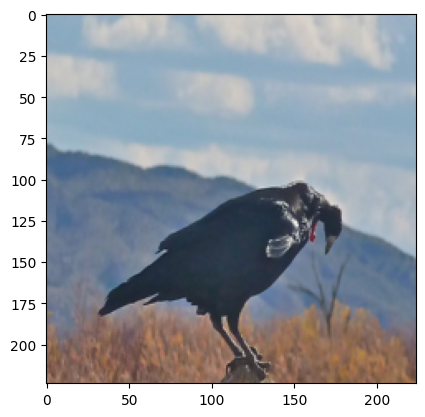

In [12]:
show_img(images[3])

In [13]:
labels[3]

tensor(107)

In [19]:
create_class_name_dict()

In [20]:
classes_dict[2]

'Laysan_Albatross'